# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [1]:
# Import libraries
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors


## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2023-06-05 18:39:19--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2023-06-05 18:39:19--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc180e5cbd8990ba8fd133ab6ecc.dl.dropboxusercontent.com/cd/0/inline/B9ad7UiCmmZwKyja3Su8OlUgkjKQh0U6Ut9wBGbeXZHrCl18nWFlvN05fGTQyOxSW3aXT9VlLPVhrpMT5dxD68ZWiuh3LhrHD1Gw9DXcAod0e7KdzWcLek7WQz1z9rvskJDZeFlFs_wSQZ9zy3niWsuq-byVfP4fOCDHLZir6EEAiA/file# [following]
--2023-06-05 18:39:20--  https://uc180e5cbd8990ba8fd133ab6ecc.dl.dropboxusercontent.com/cd/0/inline/B9ad7UiCmmZwKyja3Su8OlUgkjKQh

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

<ipython-input-3-19666a3fd1b3>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(train_images_path + "/" + train_images_files[randints[i]])
<ipython-input-3-19666a3fd1b3>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(train_labels_path + "/" + train_images_files[randints[i]])


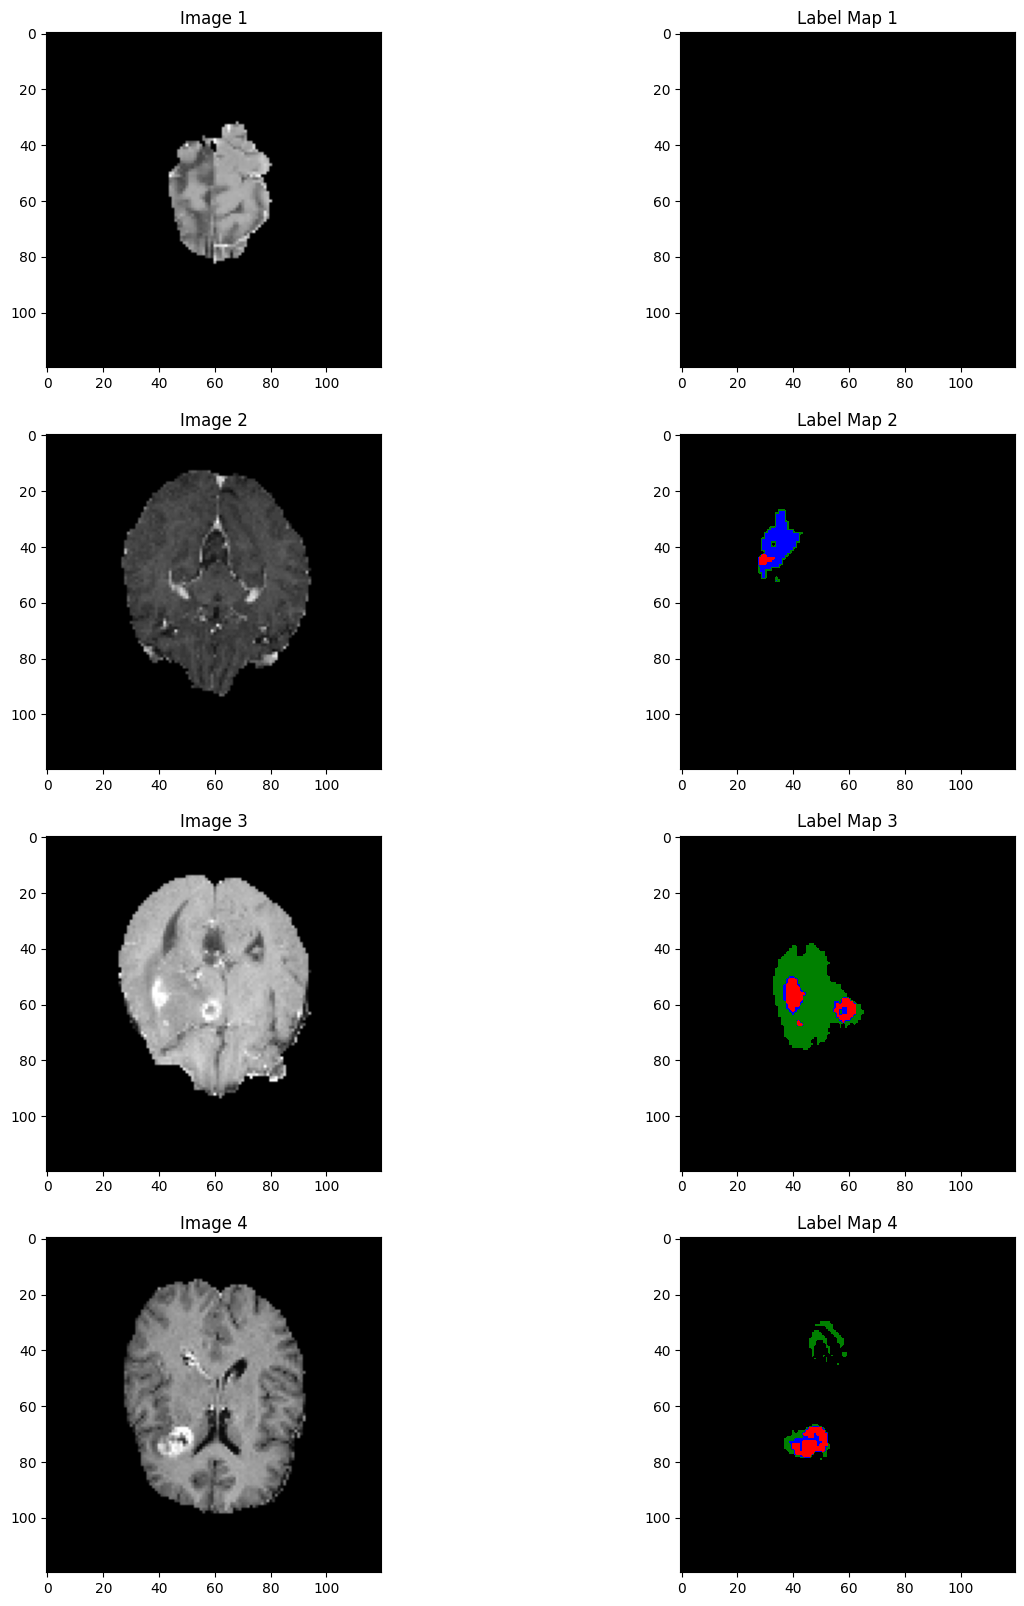

In [3]:
#Get file names for images
train_images_path = "/content/Task01_BrainTumour_2D/training_images"
train_labels_path = "/content/Task01_BrainTumour_2D/training_labels"
train_images_files = [f for f in os.listdir(train_images_path) if os.path.isfile(os.path.join(train_images_path, f))]

#Visualise the images and their label maps
fig = plt.figure(figsize=(15, 20))
rows = 4
columns = 2

cmap_img = 'gray'
cmap_label = colors.ListedColormap(['black', 'green', 'blue', 'red'])

randints = [random.randint(0, len(train_images_files)) for i in range(4)]
for i in range(len(randints)):
  
    #Image
    fig.add_subplot(rows, columns, 2*(i+1) - 1)
    image = imageio.imread(train_images_path + "/" + train_images_files[randints[i]])
    plt.imshow(image, cmap=cmap_img)
    plt.title("Image " + str(i + 1))

    #Label Map
    fig.add_subplot(rows, columns, 2*(i+1))
    image = imageio.imread(train_labels_path + "/" + train_images_files[randints[i]])
    plt.imshow(image, cmap=cmap_label)
    plt.title("Label Map " + str(i + 1))


## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [4]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        randidx = [random.randint(0, len(self)-1) for i in range(batch_size)]
        for i in range(batch_size):
            tup = self[randidx[i]]
            images.append(tup[0])
            labels.append(tup[1])

        images, labels = np.array(images)[:, np.newaxis, :, :], np.array(labels)
        return images, labels

In [5]:
# train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
# images, labels = train_set.get_random_batch(4)

# fig = plt.figure(figsize=(15, 20))
# rows = 4
# columns = 2

# cmap_img = 'gray'
# cmap_label = colors.ListedColormap(['black', 'green', 'blue', 'red'])
# for i in range(len(images)):
#   fig.add_subplot(rows, columns, 2*(i+1) - 1)
#   plt.imshow(images[i], cmap=cmap_img)
#   plt.title("Image " + str(i + 1))

#   fig.add_subplot(rows, columns, 2*(i+1))
#   plt.imshow(labels[i], cmap=cmap_label)
#   plt.title("Label Map " + str(i + 1))


## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [8]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()

        )
        
        # Decoder path
        # n = 128
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(n, int(n/2), kernel_size = 2, stride=2)  
        )

        #conv3_skip gets concatenated here
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(n, int(n/2), kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU()
        )


        n //= 2 #64
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(n, int(n/2), kernel_size = 2, stride=2)  
        )

        #conv2_skip gets concatenated here
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(n, int(n/2), kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU()
        )


        n //= 2 #32
        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(n, int(n/2), kernel_size = 2, stride=2)  
        )

        #conv1_skip gets concatenated here
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(n, int(n/2), kernel_size=3, padding=1),
            nn.BatchNorm2d(n//2),
            nn.ReLU()
        )

        n //= 2 #16
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(n, output_channel, kernel_size=1),
            # nn.BatchNorm2d(n//2)
        )



    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        
        x = self.upconv1(x)
        x = torch.concat((x, conv3_skip), 1)
        x = self.dec_conv1(x)

        x = self.upconv2(x)
        x = torch.concat((x, conv2_skip), 1)
        x = self.dec_conv2(x)

        x = self.upconv3(x)
        x = torch.concat((x, conv1_skip), 1)
        x = self.dec_conv3(x)

        x = self.dec_conv4(x)


        return x

## 4. Train the segmentation model.

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)


    # Perform optimisation and print out the training loss
    optimizer.zero_grad()
    loss = criterion(logits, labels)

    # Backward pass (compute the gradients)
    loss.backward()

    # update parameters
    optimizer.step() 
    
    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)

            loss = criterion(logits, labels)

            print("Iter:", it)
            print("Test Loss:", loss)

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda


<ipython-input-4-07ecc68a5b29>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
<ipython-input-4-07ecc68a5b29>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


Iter: 100
Test Loss: tensor(0.5457, device='cuda:0')
Iter: 200
Test Loss: tensor(0.2117, device='cuda:0')
Iter: 300
Test Loss: tensor(0.2178, device='cuda:0')
Iter: 400
Test Loss: tensor(0.1005, device='cuda:0')
Iter: 500
Test Loss: tensor(0.0817, device='cuda:0')
Iter: 600
Test Loss: tensor(0.0829, device='cuda:0')
Iter: 700
Test Loss: tensor(0.0512, device='cuda:0')
Iter: 800
Test Loss: tensor(0.0627, device='cuda:0')
Iter: 900
Test Loss: tensor(0.0482, device='cuda:0')
Iter: 1000
Test Loss: tensor(0.0619, device='cuda:0')
Iter: 1100
Test Loss: tensor(0.0318, device='cuda:0')
Iter: 1200
Test Loss: tensor(0.0455, device='cuda:0')
Iter: 1300
Test Loss: tensor(0.0409, device='cuda:0')
Iter: 1400
Test Loss: tensor(0.0387, device='cuda:0')
Iter: 1500
Test Loss: tensor(0.0453, device='cuda:0')
Iter: 1600
Test Loss: tensor(0.0324, device='cuda:0')
Iter: 1700
Test Loss: tensor(0.0500, device='cuda:0')
Iter: 1800
Test Loss: tensor(0.0402, device='cuda:0')
Iter: 1900
Test Loss: tensor(0.0428, 

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

In [7]:
def confmat(preds, true, n):
    conf_mat = np.zeros((n, n))
    for im in range(len(preds)): 
        for i in range(len(preds[0])):
            for j in range(len(preds[0])):
                pred = preds[im][i][j];
                golden = true[im][i][j];
                conf_mat[pred][golden] += 1;
    return conf_mat

def accuracy(confusion_mtx):
        return np.sum(np.diagonal(confusion_mtx))/np.sum(confusion_mtx)

def precision(confusion_mtx):
    p = np.diagonal(confusion_mtx)/np.sum(confusion_mtx,axis=0)
    macro_p = np.mean(p)
    return(p,macro_p)

def recall(confusion_mtx):
    r = np.diagonal(confusion_mtx)/np.sum(confusion_mtx,axis=1)
    macro_r = np.mean(r)
    return(r,macro_r)  

def f1_score(confusion_mtx):
    (precisions, macro_p) = precision(confusion_mtx)
    (recalls, macro_r) = recall(confusion_mtx)

    f = 2*precisions*recalls/(precisions+recalls)
    macro_f = np.mean(f) 
    
    return(f,macro_f) 

model.load_state_dict(torch.load('saved_models/model_10000.pt'))
model.eval()

test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

images, labels = train_set.get_random_batch(len(test_set))
images_t, labels_t = torch.from_numpy(images), torch.from_numpy(labels)
images_t, labels_t = images_t.to(device, dtype=torch.float32), labels_t.to(device, dtype=torch.long)



#Visualise the images and their label maps
fig = plt.figure(figsize=(15, 20))
rows = 4
columns = 3

cmap_img = 'gray'
cmap_label = colors.ListedColormap(['black', 'green', 'blue', 'red'])
preds = []
true = []

for i in range(len(images)):
    image = images[i]
    image = torch.from_numpy(image)
    image = image.to(device, dtype=torch.float32)

    prediction = model(image.unsqueeze(0))

    label = torch.from_numpy(labels[i])
    label = label.to(device, dtype=torch.long)
    if (i < 4):
        #Image
        fig.add_subplot(rows, columns, 3*(i+1) - 2)

        plt.imshow(image.cpu().squeeze(), cmap=cmap_img)
        plt.title("Image " + str(i + 1))

        #Predicted Label Map
        fig.add_subplot(rows, columns, 3*(i+1) - 1)

        plt.imshow(np.argmax(prediction.cpu().detach().numpy().squeeze(), axis = 0), cmap=cmap_label)
        plt.title("Predicted Segmentation Map " + str(i + 1))

        #True Label Map
        fig.add_subplot(rows, columns, 3*(i+1))

        plt.imshow(label.cpu().detach().numpy(), cmap=cmap_label)
        plt.title("Golden Segmentation Map " + str(i + 1))
        

    preds.append(np.argmax(prediction.cpu().detach().numpy().squeeze(), axis = 0))
    true.append(label.cpu().detach().numpy())


conf_mat = confmat(preds, true, 4)
print("Accuracy:", accuracy(conf_mat))
print("Class-wise Precision:", precision(conf_mat)[0])
print("Macro Precision:", precision(conf_mat)[1])
print("Class-wise Recall:", recall(conf_mat)[0])
print("Macro Recall:", recall(conf_mat)[1])
print("Class-wise F1 Score:", f1_score(conf_mat)[0])
print("Macro F1 Score:", f1_score(conf_mat)[1])
print("Confusion Matrix:\n", conf_mat)


  #Predicted Label Map
### End of your code ###

NameError: ignored

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

##**Performance of the model**

1. A first glance at the model's predicted segmentation maps vs the golden segmentation maps shows that the model can differentiate between background, edema, enhancing tumours, and non-enhancing tumours quite well with detection being in roughly the same place as the golden.


2. During training, the categorical cross entropy loss is 0.00648 which is fairly low. However, most of the images in the dataset suffer from severe class imbalance  since most of the image is labelled as the background. Hence, categorical cross may not be the ideal loss function. 

3. The test loss seems to plateau after about 1000 iterations which means we are overfitting the model during training.

4. The accuracy of the model is high. However, most of the images in the dataset suffer from severe class imbalance in the dataset since most of the image is labelled as the background. Therefore, the accuracy is not the best metric to look at. The class-wise precision, recall, and f1-score reveal how well the model performs for different classes and it can be seen that the metrics are highest for class 0, i.e. the background and lower for the other classes.


##**Possible Improvements Before Deployment**
1. A weighted cross-entropy loss function could be used which weighs the detection classes more heavily than the background. This would fix the imbalanced dataset issue mentioned early. It would also reduce false negatives for tumour detection and increase recall which is good since diagnosis clinic should prioritise detecting tumours and should not miss tumours which would get worse without treatment.

2. Overfitting could be fixed by using an early stopping mechanism during training that makes use of a train-val-test split.

3. The dataset only has 2028 images which is not that large of a datatset. This issue can be mitigated by data-augmentaion; this would involve flipping images, scaling, and rotations etc.

4. Since the training time with GPUs is not that long (~300s), we run many training training iteration for hyperparameter tuning or even experiement with network architecture to find a better architecture.






In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp "./drive/My Drive/Colab Notebooks/coursework_02.ipynb" ./

!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf "coursework_02.ipynb"

Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 javascript-common libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn11 libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6
  libpdfbox-java libptexenc1 libruby2.7 libsynctex2 libteckit0 libtexlua53
  libtexluajit2 libzzip-0-13 lmodern poppler-data preview-latex-style rake
  ruby ruby-minitest ruby-net-telnet ruby-power-assert ruby-test-unit
  ruby-xmlrpc ruby2.7 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf apache2 | l